# State Schema (pydantic 중심)
- State Schema는 랭그래프가 사용할 데이터의 구조와 타입을 정의한다.
- 모든 Node는 이 Schema 구조에 따라 소통한다. 
- Schema를 정의하는 라이브러리에는 TypeDict, Dataclass 방식도 있으나, 이 방식들은 구조에 맞지 않는 값이 들어오는 경우도 에러를 발생시키지 않는다.
- pydandic은 구조에 맞지 않은 값이 들어오면 에러를 발생시킬 수 있어, 가장 안정적으로 Schema를 구성할 수 있다.

In [1]:
from pydantic import BaseModel, field_validator, ValidationError
from typing import Literal

class PydanticState(BaseModel):
    name: str
    mood: str

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

In [2]:
try:
    state = PydanticState(name="John Doe", mood="mad")    # 에러 발생시킴
    # state = PydanticState(name="John Doe", mood="sad")
except ValidationError as e:
    print("Validation Error:", e)


Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


# Langraph 구성하기

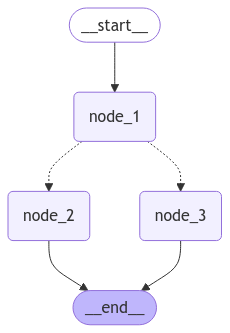

In [3]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:
        # 50% of the time, we return Node 2
        return "node_2"
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
state = PydanticState(name="Lance", mood="sad")
state.name

'Lance'

In [5]:
graph.invoke(PydanticState(name="Lance", mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

# State Reducer
- 단어가 어려우나, 노드가 분개되어 프로세스가 병렬로 진행되는 상황에서 State Schema 업데이트가 양쪽에서 동시에 발생하는 경우 복수의 업데이트 값을 어떻게 처리할 것인가?
- 복수의 결과 값들을 리스트에 append 하는 방식으로 해결한다. ---> Annotated type을 사용할 수 있다.

```
Reducers are key to understanding how updates from nodes are applied to the State. Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it. There are a few different types of reducers, starting with the default type of reducer:
```

### 단순 직렬 연결 예시

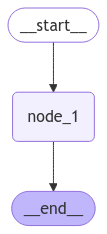

In [6]:
from operator import add
from typing import Annotated

class State(BaseModel):
    foo: Annotated[list[int], add]    # Annoated 사용을 통해 list[int] 변수에 add 함수를 적용하는 관계를 정의

def node_1(state):
    print("---Node 1---")
    return {"foo": [state.foo[0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

### 병렬 연결 예시

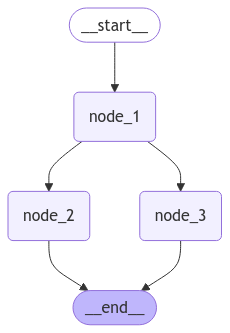

In [8]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state.foo[-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state.foo[-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state.foo[-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

### built-in reducer : add_message or MessageState

In [10]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

In [11]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
result = add_messages(initial_messages , new_message)
print(len(result))
result

3


[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='a4c41723-1395-464a-8429-752ae979cea0'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='f694ef75-e029-4d74-a3e7-34114d7de9c6'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='d3a0c3af-a35c-4d84-bfd0-56e6a9ba9437')]

In [12]:
## id 값을 추가하고, 같은 id 값이면 overwrite 한다.

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

In [13]:
## 메모리 효율화를 위해 끝에 두개만 남기고 지우기
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
print(len(messages))
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(len(delete_messages))
print(delete_messages)

4
2
[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


# Simple Langgraph Chatbot (memory with last 4 pair sentences)

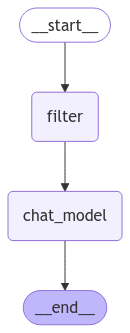

In [14]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    print(f">>> 필터 전 리스트 길이 : {len(state["messages"])}")
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-4]]
    print(f">>> 필터 후 리스트 길이 : {len(state["messages"]) - len(delete_messages)}")
    return {"messages": delete_messages}

from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langchain_core.messages import AIMessage, HumanMessage

messages = []
messages = [AIMessage("Hi.", name="Bot", id=str(len(messages)))]

question = "what is the capital of south korea?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})

messages.append(output['messages'][-1])
messages

question = "what is the capital of japan?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})
messages.append(output['messages'][-1])


question = "what is the capital of china?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})
messages.append(output['messages'][-1])

question = "what is the distance between two capitals ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})
messages.append(output['messages'][-1])

question = "let me know the all capitals that is previously discussed ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages})
messages.append(output['messages'][-1])

for m in output['messages']:
    m.pretty_print()

>>> 필터 전 리스트 길이 : 2
>>> 필터 후 리스트 길이 : 2
>>> 필터 전 리스트 길이 : 4
>>> 필터 후 리스트 길이 : 4
>>> 필터 전 리스트 길이 : 6
>>> 필터 후 리스트 길이 : 4
>>> 필터 전 리스트 길이 : 8
>>> 필터 후 리스트 길이 : 4
>>> 필터 전 리스트 길이 : 10
>>> 필터 후 리스트 길이 : 4
================================== Ai Message ==================================

The capital of China is Beijing.
================================ Human Message =================================
Name: Kim

what is the distance between two capitals ?
================================== Ai Message ==================================

To calculate the distance between the two capitals, I'll need to know the specific capitals you're referring to. However, I can give you the approximate distance between Tokyo, Japan, and Beijing, China.

The distance between Tokyo, Japan, and Beijing, China is approximately 1,864 kilometers (1,157 miles).
================================ Human Message =================================
Name: Kim

let me know the all capitals that is previously discussed ?
======

In [16]:
len(output["messages"])

5

In [17]:
output["messages"]

[AIMessage(content='The capital of China is Beijing.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 79, 'total_tokens': 87, 'completion_time': 0.010666667, 'prompt_time': 0.010754523, 'queue_time': 0.003900697, 'total_time': 0.02142119}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-7607128e-d2bc-4cbe-9e97-ada401504d44-0', usage_metadata={'input_tokens': 79, 'output_tokens': 8, 'total_tokens': 87}),
 HumanMessage(content='what is the distance between two capitals ?', additional_kwargs={}, response_metadata={}, name='Kim', id='7'),
 AIMessage(content="To calculate the distance between the two capitals, I'll need to know the specific capitals you're referring to. However, I can give you the approximate distance between Tokyo, Japan, and Beijing, China.\n\nThe distance between Tokyo, Japan, and Beijing, China is approximately 1,864 kilometers (1,157 miles

In [18]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='0'),
 HumanMessage(content='what is the capital of south korea?', additional_kwargs={}, response_metadata={}, name='Kim', id='1'),
 AIMessage(content='The capital of South Korea is Seoul.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 51, 'total_tokens': 60, 'completion_time': 0.012, 'prompt_time': 0.005654654, 'queue_time': 0.008612236, 'total_time': 0.017654654}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-c404485d-16a9-4f2a-afd9-e560c738b1a6-0', usage_metadata={'input_tokens': 51, 'output_tokens': 9, 'total_tokens': 60}),
 HumanMessage(content='what is the capital of japan?', additional_kwargs={}, response_metadata={}, name='Kim', id='3'),
 AIMessage(content='The capital of Japan is Tokyo.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tok

# Message Summarization and Memory

In [19]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")


In [20]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

In [21]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [22]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [23]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

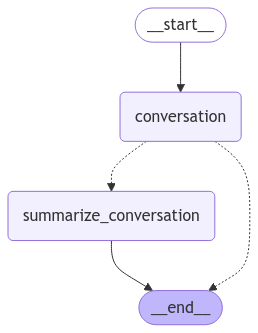

In [24]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

messages = []
messages = [AIMessage("Hi.", name="Bot", id=str(len(messages)))]

question = "what is the capital of south korea?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)

messages.append(output['messages'][-1])
messages

question = "what is the capital of japan?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the capital of china?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the distance between two capitals ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "let me know the all capitals that is previously discussed ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Kim

let me know the all capitals that is previously discussed ?
================================== Ai Message ==================================

Here are the capitals we previously discussed:

1. South Korea: Seoul
2. Japan: Tokyo
3. China: Beijing


In [26]:
output['messages']

[HumanMessage(content='let me know the all capitals that is previously discussed ?', additional_kwargs={}, response_metadata={}, name='Kim', id='9'),
 AIMessage(content='Here are the capitals we previously discussed:\n\n1. South Korea: Seoul\n2. Japan: Tokyo\n3. China: Beijing', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 398, 'total_tokens': 425, 'completion_time': 0.036, 'prompt_time': 0.025534741, 'queue_time': 0.001904144, 'total_time': 0.061534741}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-edb89616-b961-4dcb-9159-7bf0de19a7a3-0', usage_metadata={'input_tokens': 398, 'output_tokens': 27, 'total_tokens': 425})]

In [27]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='0'),
 HumanMessage(content='what is the capital of south korea?', additional_kwargs={}, response_metadata={}, name='Kim', id='1'),
 AIMessage(content='The capital of South Korea is Seoul.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 51, 'total_tokens': 60, 'completion_time': 0.012, 'prompt_time': 0.006929927, 'queue_time': 0.007777033, 'total_time': 0.018929927}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None}, id='run-c33213bd-4a7a-4194-8408-ee512785e21c-0', usage_metadata={'input_tokens': 51, 'output_tokens': 9, 'total_tokens': 60}),
 HumanMessage(content='what is the capital of japan?', additional_kwargs={}, response_metadata={}, name='Kim', id='3'),
 AIMessage(content='The capital of Japan is Tokyo.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tok

# Message summarization & external DB memory
- https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/  나중에 postgres로 변환

In [28]:
import sqlite3
# In memory
db_path = "db/ex_memory_09.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
conn

In [29]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)
memory

In [30]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

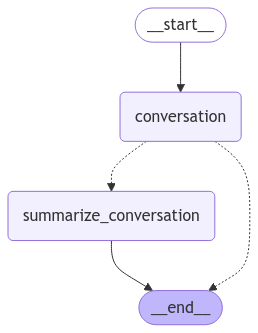

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

messages = []
messages = [AIMessage("Hi.", name="Bot", id=str(len(messages)))]

question = "what is the capital of south korea?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)

messages.append(output['messages'][-1])
messages

question = "what is the capital of japan?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the capital of china?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the distance between two capitals ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "let me know the all capitals that is previously discussed ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Kim

let me know the all capitals that is previously discussed ?
================================== Ai Message ==================================

Here are the capitals we previously discussed:

1. South Korea: Seoul
2. Japan: Tokyo
3. China: Beijing


In [33]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='let me know the all capitals that is previously discussed ?', additional_kwargs={}, response_metadata={}, name='Kim', id='9'), AIMessage(content='Here are the capitals we previously discussed:\n\n1. South Korea: Seoul\n2. Japan: Tokyo\n3. China: Beijing', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 398, 'total_tokens': 425, 'completion_time': 0.036, 'prompt_time': 0.025840848, 'queue_time': 0.0025513719999999997, 'total_time': 0.061840848}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-f83cfed8-28a5-42f2-94a4-f63540f1594e-0', usage_metadata={'input_tokens': 398, 'output_tokens': 27, 'total_tokens': 425})], 'summary': "Here's the updated summary of our conversation:\n\nWe discussed the capitals of four countries in East Asia:\n\n1. South Korea: Seoul\n2. Japan: Tokyo\n3. China: Beijing\n4. We al

In [34]:
graph_state.values

{'messages': [HumanMessage(content='let me know the all capitals that is previously discussed ?', additional_kwargs={}, response_metadata={}, name='Kim', id='9'),
  AIMessage(content='Here are the capitals we previously discussed:\n\n1. South Korea: Seoul\n2. Japan: Tokyo\n3. China: Beijing', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 398, 'total_tokens': 425, 'completion_time': 0.036, 'prompt_time': 0.025840848, 'queue_time': 0.0025513719999999997, 'total_time': 0.061840848}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-f83cfed8-28a5-42f2-94a4-f63540f1594e-0', usage_metadata={'input_tokens': 398, 'output_tokens': 27, 'total_tokens': 425})],
 'summary': "Here's the updated summary of our conversation:\n\nWe discussed the capitals of four countries in East Asia:\n\n1. South Korea: Seoul\n2. Japan: Tokyo\n3. China: Beijing\n4. We also calculated the 

In [35]:
import os
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from sqlalchemy import text, inspect

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///./db/ex_memory_09.db")
engine = create_engine(DATABASE_URL)

def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

schema = get_database_schema(engine=engine)
print(schema)

Retrieved database schema.
Table: checkpoints
- thread_id: TEXT, Primary Key
- checkpoint_ns: TEXT, Primary Key
- checkpoint_id: TEXT, Primary Key
- parent_checkpoint_id: TEXT
- type: TEXT
- checkpoint: BLOB
- metadata: BLOB

Table: writes
- thread_id: TEXT, Primary Key
- checkpoint_ns: TEXT, Primary Key
- checkpoint_id: TEXT, Primary Key
- task_id: TEXT, Primary Key
- idx: INTEGER, Primary Key
- channel: TEXT
- type: TEXT
- value: BLOB




In [36]:
conn = sqlite3.connect('./db/ex_memory_09.db')
cursor = conn.cursor()

query = "SELECT * FROM checkpoints"
cursor.execute(query)

# Fetch all rows from the result
rows = cursor.fetchall()

# Iterate over the rows and print the data
for row in rows:
    print(row)

# Close the cursor and the connection
cursor.close()
conn.close()

('1', '', '1efa9256-69cf-6d84-bfff-63dcfef99edd', None, 'msgpack', b'\x87\xa1v\x01\xa2ts\xd9 2024-11-22T22:59:17.222336+00:00\xa2id\xd9$1efa9256-69cf-6d84-bfff-63dcfef99edd\xaechannel_values\x81\xa9__start__\x81\xa8messages\x92\xc7\xbc\x05\x94\xbalangchain_core.messages.ai\xa9AIMessage\x8a\xa7content\xa3Hi.\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa2ai\xa4name\xa3Bot\xa2id\xa10\xa7example\xc2\xaatool_calls\x90\xb2invalid_tool_calls\x90\xaeusage_metadata\xc0\xb3model_validate_json\xc7\xb6\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9#what is the capital of south korea?\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xa3Kim\xa2id\xa11\xa7example\xc2\xb3model_validate_json\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.8772266582026554\xadversions_seen\x81\xa9__input__\x80\xadpending_sends\x90', b'{"source": "input", "writes": {"__start__": {"messages": [{"lc": 1, "type": "constructor",

# Streaming

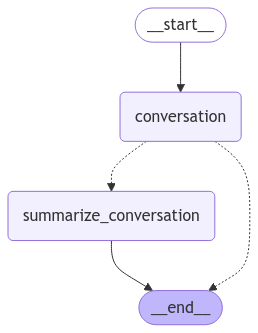

In [37]:
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
from langchain_groq import ChatGroq
model = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

messages = []
messages = [AIMessage("Hi.", name="Bot", id=str(len(messages)))]

question = "what is the capital of south korea?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)

messages.append(output['messages'][-1])
messages

question = "what is the capital of japan?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the capital of china?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "what is the distance between two capitals ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

question = "let me know the all capitals that is previously discussed ?"
messages.append(HumanMessage(question, name="Kim", id=str(len(messages))))
output = graph.invoke({'messages': messages}, config)
messages.append(output['messages'][-1])

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Kim

let me know the all capitals that is previously discussed ?
================================== Ai Message ==================================

Here are the capitals we previously discussed:

1. South Korea: Seoul
2. Japan: Tokyo
3. China: Beijing


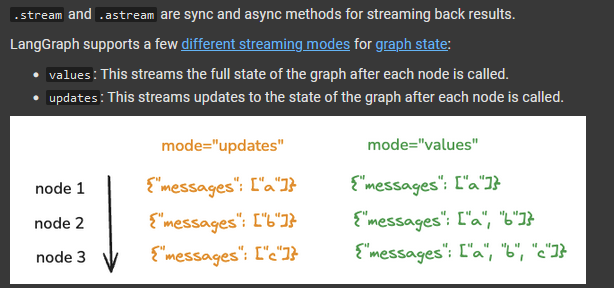

In [39]:
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="what is the capital of USA")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='The capital of the United States of America (USA) is Washington, D.C. (short for District of Columbia).', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 299, 'total_tokens': 324, 'completion_time': 0.033333333, 'prompt_time': 0.019433081, 'queue_time': 0.0023107359999999973, 'total_time': 0.052766414}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-e337c8e1-fd0f-45b1-8389-733fa2e2e135-0', usage_metadata={'input_tokens': 299, 'output_tokens': 25, 'total_tokens': 324})}}


In [40]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance, it's nice to meet you. Is there something I can help you with or would you like to chat?
---------------------------------------------------------------------------


In [41]:
"""
We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

    event: This is the type of event that is being emitted.
    name: This is the name of event.
    data: This is the data associated with the event.
    metadata: Containslanggraph_node, the node emitting the event.

"""

config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_c

In [42]:
"""
The central point is that tokens from chat models within your graph have the on_chat_model_stream type.
We can use event['metadata']['langgraph_node'] to select the node to stream from.
And we can use event['data'] to get the actual data for each event, which in this case is an AIMessageChunk.
"""

node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="what is the capital of japan")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content=' capital', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content=' Japan', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content=' Tokyo', additional_kwargs={}, response_metadata={}, id='run-458ab737-fe49-48b0-a7a9-dff1127dac17')}
{'chunk': AIMessageChunk(content='.', additional_kwargs={}, response

In [43]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="what is the capital of japan")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| capital| of| Japan| is| Tokyo|.||

# Breakpoints

Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

First, we'll introduce breakpoints, which provide a simple way to stop the graph at specific steps.

We'll show how this enables user approval.

In [44]:
# LLM
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

In [45]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A808BC21B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A808BBF200>, model_name='llama-3.1-8b-instant', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'de

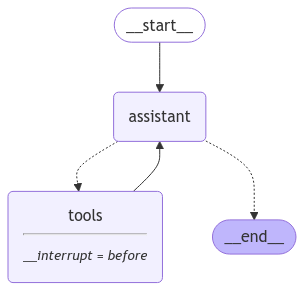

In [64]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

'''
Let's re-consider the simple agent that we worked with in Module 1.
Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
All we need to do is simply compile the graph with interrupt_before=["tools"] where tools is our tools node.
This means that the execution will be interrupted before the node tools, which executes the tool call.
'''

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [65]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 4")}

# Thread
thread = {"configurable": {"thread_id": "20"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    # print(event)
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jt9x)
 Call ID: call_jt9x
  Args:
    a: 2
    b: 4


In [66]:
state = graph.get_state(thread)
state.next

('tools',)

In [67]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_jt9x)
 Call ID: call_jt9x
  Args:
    a: 2
    b: 4
================================= Tool Message =================================
Name: multiply

8
================================== Ai Message ==================================
Tool Calls:
  add (call_cvdm)
 Call ID: call_cvdm
  Args:
    a: 2
    b: 4


In [ ]:
### 전체 프로세스 연결해보기 #####################
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "21"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution  (When we invoke the graph with None, it will just continue from the last state checkpoint!)
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6t0t)
 Call ID: call_6t0t
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6t0t)
 Call ID: call_6t0t
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of the multiplication is 6.


# Editing Graph State
- We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!
- Now, let's show how to directly edit the graph state and insert human feedback.

In [72]:
# LLM
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

In [73]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

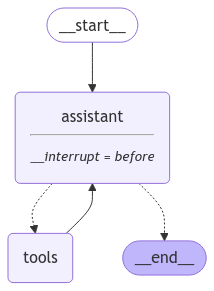

In [74]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [75]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [76]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c63ed846-ffea-4886-8e8a-88c9ebc697a6')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9280-62e1-6a7f-8000-cf52e37aaf3c'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-11-22T23:18:03.924543+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9280-62db-64c9-bfff-f8e7637d1b02'}}, tasks=(PregelTask(id='386dbeb5-ecf0-f25e-7113-c47c555586e7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [77]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9281-bbda-619f-8001-d03c0e960e91'}}

In [79]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [80]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_61e7)
 Call ID: call_61e7
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [81]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5jhk)
 Call ID: call_5jhk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


## ALL in One

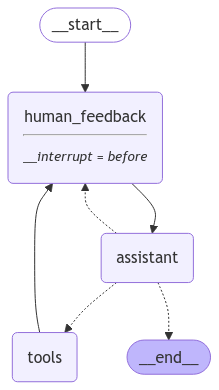

In [87]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
#### ALL in One
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

multiply 100 and 2
================================== Ai Message ==================================

<multiply>{"a": 100, "b": 2}</multiply>


# Dynamic Breakpoints
- Breakpoints are set by the developer on a specific node during graph compilation.
- But, sometimes it is helpful to allow the graph dynamically interrupt itself!
- This is an internal breakpoint, and can be achieved using NodeInterrupt.
- This has a few specific benefits:
- (1) you can do it conditionally (from inside a node based on developer-defined logic).
- (2) you can communicate to the user why its interrupted (by passing whatever you want to the NodeInterrupt).

In [90]:
# LLM
from langchain_groq import ChatGroq
model = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

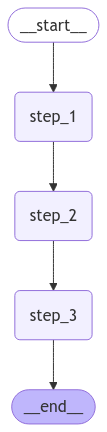

In [109]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [110]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "100"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)
    state = graph.get_state(thread_config)
    print(state.next)

{'input': 'hello world'}
('step_1',)
---Step 1---
{'input': 'hello world'}
('step_1',)


In [112]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)
state = graph.get_state(thread_config)
print(state.next)   ## None으로 재요청을 날려도 상태가 진행되지 않는다.

{'input': 'hello world'}
('step_2',)


In [113]:
graph.update_state(
    thread_config,
    {"input": "hi"},     # 글자수 5개 미만 조건을 충족하도록 state를 업데이트해야 상태가 진행된다.
)
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)
    state = graph.get_state(thread_config)
    print(state.next)   ## None으로 재요청을 날려도 상태가 진행되지 않는다.

{'input': 'hi'}
('step_2',)
---Step 2---
{'input': 'hi'}
('step_2',)
---Step 3---
{'input': 'hi'}
()


# Time Travel (debugging)
- Now, let's show how LangGraph supports debugging by viewing, re-playing, and even forking from past states.
- We call this time travel.

In [116]:
# LLM
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

In [119]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

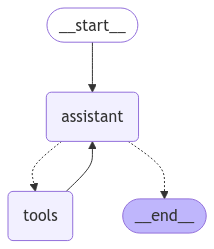

In [120]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [121]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1000"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gnrb)
 Call ID: call_gnrb
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of the multiplication is 6.


In [123]:
## We can use get_state to look at the current state of our graph, given the thread_id!

graph.get_state({'configurable': {'thread_id': '1000'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gnrb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_tokens': 390, 'completion_time': 0.025333333, 'prompt_time': 0.023863603, 'queue_time': 0.0025797270000000004, 'total_time': 0.049196936}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9736ef79-bbb0-4427-9c20-bce149f89edd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_gnrb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}), ToolMessage(content='6', name='multiply', id='32adcd1a-238f-4920-9ac9-67b140cc73da',

In [124]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

5

In [127]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gnrb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_tokens': 390, 'completion_time': 0.025333333, 'prompt_time': 0.023863603, 'queue_time': 0.0025797270000000004, 'total_time': 0.049196936}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9736ef79-bbb0-4427-9c20-bce149f89edd-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_gnrb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}), ToolMessage(content='6', name='multiply', id='32adcd1a-238f-4920-9ac9-67b140cc73da'

In [129]:
all_states[-2]   # The first element is the current state, just as we got from get_state.

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde')]}, next=('assistant',), config={'configurable': {'thread_id': '1000', 'checkpoint_ns': '', 'checkpoint_id': '1efa92af-fda5-6776-8000-54a5275759f6'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-11-22T23:39:21.799461+00:00', parent_config={'configurable': {'thread_id': '1000', 'checkpoint_ns': '', 'checkpoint_id': '1efa92af-fda4-60f5-bfff-9126cca11c12'}}, tasks=(PregelTask(id='0d239ea2-e437-2676-d0f9-53262ed0a780', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gnrb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_token

## RE-play

In [130]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde')]}, next=('assistant',), config={'configurable': {'thread_id': '1000', 'checkpoint_ns': '', 'checkpoint_id': '1efa92af-fda5-6776-8000-54a5275759f6'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-11-22T23:39:21.799461+00:00', parent_config={'configurable': {'thread_id': '1000', 'checkpoint_ns': '', 'checkpoint_id': '1efa92af-fda4-60f5-bfff-9126cca11c12'}}, tasks=(PregelTask(id='0d239ea2-e437-2676-d0f9-53262ed0a780', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gnrb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_token

In [131]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde')]}

In [132]:
to_replay.config

{'configurable': {'thread_id': '1000',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa92af-fda5-6776-8000-54a5275759f6'}}

In [133]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_29zd)
 Call ID: call_29zd
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of the multiplication is 6.


## Fork
- What if we want to run from that same step, but with a different input.

In [134]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde')]

In [135]:
to_fork.config

{'configurable': {'thread_id': '1000',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa92af-fda5-6776-8000-54a5275759f6'}}

In [137]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)
fork_config

{'configurable': {'thread_id': '1000',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa92be-f9cb-623b-8001-eebe973e3a42'}}

In [138]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde')]

In [141]:
graph.get_state({'configurable': {'thread_id': '1000'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9a0b886d-6ed6-4b47-b02b-8c23cc3bacde'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xh92', 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_tokens': 390, 'completion_time': 0.025333333, 'prompt_time': 0.023800913, 'queue_time': 0.0021201019999999987, 'total_time': 0.049134246}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c55754c5-788a-4023-a7f0-885cf7113641-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_xh92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}), ToolMessage(content='15', name='multiply', id='3010a83e-9e17-4c5e-898a-31429bc347c1'

In [142]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_n464)
 Call ID: call_n464
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================
Tool Calls:
  divide (call_ddsh)
 Call ID: call_ddsh
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: divide

3.0
================================== Ai Message ==================================
Tool Calls:
  divide (call_jmjv)
 Call ID: call_jmjv
  Args:
    a: 15
    b: 3
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================
Tool Calls:
  add (call_aa11)
 Call ID

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

# Parallel node execution
- https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution

In [143]:
# LLM
from langchain_groq import ChatGroq
model = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

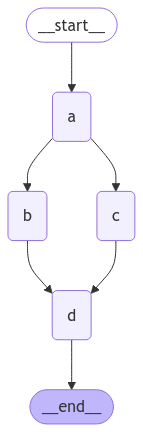

In [144]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}
    
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [151]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"병렬처리 error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
병렬처리 error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


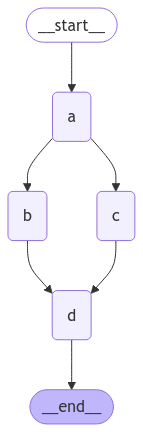

In [155]:
import operator
from typing import Annotated

class State(TypedDict):  # 복수의 결과를 리스트에 담을 수 있는 형태로 변경
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}
    
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [156]:
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"병렬처리 error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


## Real Case (tavily and wiki)

In [159]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

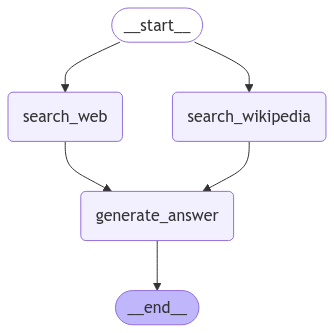

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [168]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings exceeded consensus expectations. The company reported $0.81 adjusted earnings per share, or $19.3 billion net income, in the three-month period ending last month, topping average analyst projections of $0.75 EPS, or $17.4 billion net income, according to FactSet. The semiconductor chip architect generated $35.1 billion in sales, crushing estimates of $33.2 billion."

In [169]:
result

{'question': "How were Nvidia's Q2 2024 earnings",
 'answer': AIMessage(content="Nvidia's Q2 2024 earnings exceeded consensus expectations. The company reported $0.81 adjusted earnings per share, or $19.3 billion net income, in the three-month period ending last month, topping average analyst projections of $0.75 EPS, or $17.4 billion net income, according to FactSet. The semiconductor chip architect generated $35.1 billion in sales, crushing estimates of $33.2 billion.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 2435, 'total_tokens': 2526, 'completion_time': 0.121333333, 'prompt_time': 0.158673813, 'queue_time': 0.0025635310000000078, 'total_time': 0.280007146}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-5f26838f-ec3b-47c2-84ba-57b7b4b0de96-0', usage_metadata={'input_tokens': 2435, 'output_tokens': 91, 'total_tokens': 2526}),
 'context': ['<Doc

# Sub-Graph
```
Sub-graphs allow you to create and manage different states in different parts of your graph.

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

    I have a system that accepts logs
    It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
    I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate!

In short, communication is done with over-lapping keys:

    The sub-graphs can access docs from the parent
    The parent can access summary/failure_report from the sub-graphs

```

In [170]:
# LLM
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

In [171]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Here is the failure analysis sub-graph, which uses FailureAnalysisState.

C:\Users\jongb\AppData\Local\Temp\ipykernel_20828\1870112535.py:28: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)


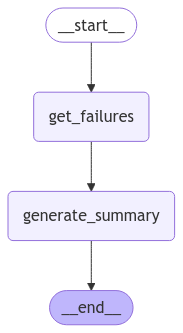

In [172]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Here is the question summarization sub-grap, which uses QuestionSummarizationState.

C:\Users\jongb\AppData\Local\Temp\ipykernel_20828\1669619007.py:24: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)


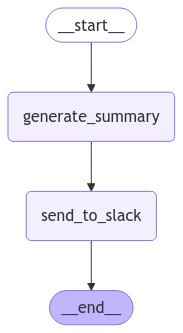

In [174]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

In [175]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

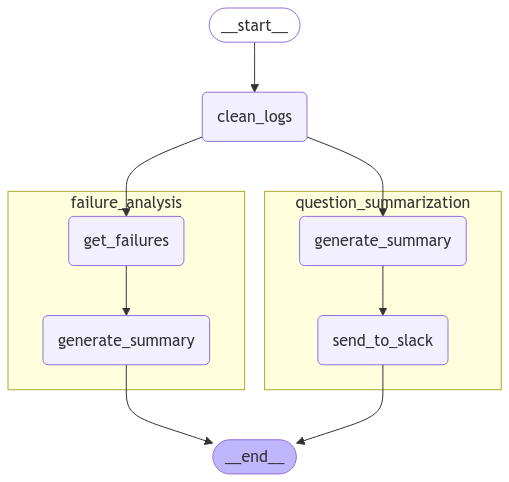

In [176]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [178]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

# Map-Reduce
- https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

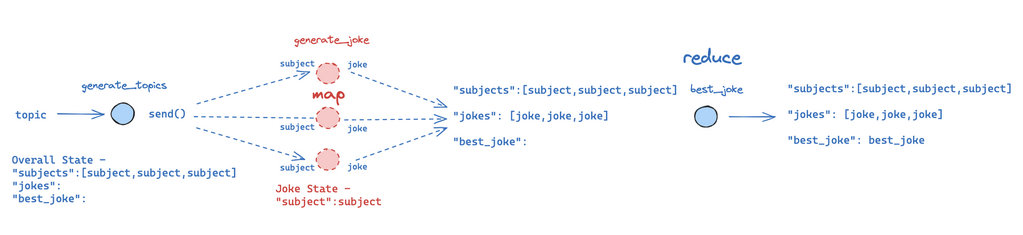

```
Map-reduce operations are essential for efficient task decomposition and parallel processing.
It has two phases:
(1) Map - Break a task into smaller sub-tasks, processing each sub-task in parallel.
(2) Reduce - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:
(1) Map - Create a set of jokes about a topic.
(2) Reduce - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.
```

In [194]:
# LLM
from langchain_groq import ChatGroq
model = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

# Prompts we will use
subjects_prompt = """Generate a list of 4 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""


In [195]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [196]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [197]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

""" 
Here is the magic: we use the Send to create a joke for each subject.
This is very useful! It can automatically parallelize joke generation for any number of subjects.
    generate_joke: the name of the node in the graph
    {"subject": s}: the state to send

Send allow you to pass any state that you want to generate_joke! It does not have to align with OverallState.
In this case, generate_joke is using its own internal state, and we can popular this via Send.
"""

' \nHere is the magic: we use the Send to create a joke for each subject.\nThis is very useful! It can automatically parallelize joke generation for any number of subjects.\n    generate_joke: the name of the node in the graph\n    {"subject": s}: the state to send\n\nSend allow you to pass any state that you want to generate_joke! It does not have to align with OverallState.\nIn this case, generate_joke is using its own internal state, and we can popular this via Send.\n'

## Map

In [198]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

## Reduce

In [199]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile

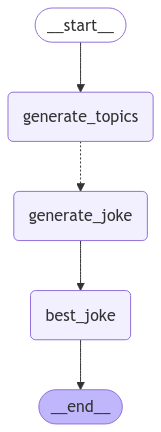

In [200]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [201]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'reptiles', 'amphibians', 'birds']}}
{'generate_joke': {'jokes': ['Why did the cat join a band? Because it wanted to be the purr-cussionist!']}}
{'generate_joke': {'jokes': ['Why did the frog go to the doctor? Because it wasn’t feeling well-toed!']}}
{'generate_joke': {'jokes': ['Why did the bird go to the doctor? It had a fowl cough!']}}
{'generate_joke': {'jokes': ['Why did the reptile go to the party? Because he was a snappy dresser!']}}
{'best_joke': {'best_selected_joke': 'Why did the cat join a band? Because it wanted to be the purr-cussionist!'}}


# END